In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.cluster import KMeans

# House Data

In [3]:
house_df = pd.read_csv('../Data/1976-2022-house.csv')
print(house_df.shape)
house_df = house_df[['year', 'state', 'state_po', 'party', 'candidatevotes', 'totalvotes', 'unofficial', 'district']]
house_df.head()

(32452, 20)


,year,state,state_po,party,candidatevotes,totalvotes,unofficial,district
0,1976,ALABAMA,AL,DEMOCRAT,58906,157170,False,1
1,1976,ALABAMA,AL,REPUBLICAN,98257,157170,False,1
2,1976,ALABAMA,AL,NaN,7,157170,False,1
3,1976,ALABAMA,AL,DEMOCRAT,66288,156362,False,2
4,1976,ALABAMA,AL,REPUBLICAN,90069,156362,False,2


In [4]:
# Won't count votes if the party is NaN, so replace with OTHER
house_df['party'].fillna('OTHER', inplace=True)
house_df.head()

,year,state,state_po,party,candidatevotes,totalvotes,unofficial,district
0,1976,ALABAMA,AL,DEMOCRAT,58906,157170,False,1
1,1976,ALABAMA,AL,REPUBLICAN,98257,157170,False,1
2,1976,ALABAMA,AL,OTHER,7,157170,False,1
3,1976,ALABAMA,AL,DEMOCRAT,66288,156362,False,2
4,1976,ALABAMA,AL,REPUBLICAN,90069,156362,False,2


In [5]:
# Only want elections that are official and on 2020 or 2022
house_df_2020_on = house_df.query('year >= 2020 and unofficial == False')
print(house_df_2020_on.shape)
house_df_2020_on.head()

(2816, 8)


,year,state,state_po,party,candidatevotes,totalvotes,unofficial,district
29636,2020,ALABAMA,AL,DEMOCRAT,116949,329075,False,1
29637,2020,ALABAMA,AL,REPUBLICAN,211825,329075,False,1
29638,2020,ALABAMA,AL,OTHER,301,329075,False,1
29639,2020,ALABAMA,AL,REPUBLICAN,197996,303569,False,2
29640,2020,ALABAMA,AL,DEMOCRAT,105286,303569,False,2


In [6]:
# We don't care about the districts so sum the votes for a party across all districts
votes_by_year_state_party = house_df_2020_on.groupby(['year', 'state_po', 'party'])['candidatevotes'].sum()
votes_by_year_state_party

year  state_po  party       
2020  AK        DEMOCRAT        159856
                OTHER             1183
                REPUBLICAN      192126
      AL        DEMOCRAT        608809
                OTHER            26838
                                 ...  
2022  WY        CONSTITUTION      4505
                DEMOCRAT         47250
                LIBERTARIAN       5420
                OTHER             8817
                REPUBLICAN      132206
Name: candidatevotes, Length: 469, dtype: int64

In [7]:
list(votes_by_year_state_party[2022]['SD'].items())

[('LIBERTARIAN', 74020), ('REPUBLICAN', 253821)]

In [8]:
votes_by_year_state_party[2020]['SD']

party
LIBERTARIAN     75748
REPUBLICAN     321984
Name: candidatevotes, dtype: int64

In [9]:
years = [2020, 2022]
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 
        'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 
        'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 
        'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
print(len(states))
main_parties = ['DEMOCRAT', 'REPUBLICAN']

50


In [10]:
# make a dictionary where the first key:value is year:rest
# next is state:rest
# final is one of three parties (Democrat, Republican, Other) and their vote counts
# votes => first is year:states => states:parties => parties:votes
# votes[year][state][party] = votes
votes = {}
for year in years:
    votes[year] = {}
    for state in states:
        votes[year][state] = defaultdict(int)
        parties = list(votes_by_year_state_party[year][state].keys())
        for party in parties:
            if party in main_parties:
                votes[year][state][party] += votes_by_year_state_party[year][state][party]
            else:
                flag = True
                for mparty in main_parties:
                    if mparty in party:
                        votes[year][state][mparty] += votes_by_year_state_party[year][state][party]
                        flag = False
                        break
                
                if flag:
                    votes[year][state]['OTHER'] += votes_by_year_state_party[year][state][party]
        votes[year][state] = dict(votes[year][state])
        if 'OTHER' not in votes[year][state].keys():
            votes[year][state]['OTHER'] = 0
        if 'DEMOCRAT' not in votes[year][state].keys():
            votes[year][state]['DEMOCRAT'] = 0
        if 'REPUBLICAN' not in votes[year][state].keys():
            votes[year][state]['REPUBLICAN'] = 0

print(votes[2020])

{'AL': {'DEMOCRAT': 608809, 'OTHER': 26838, 'REPUBLICAN': 1416012}, 'AK': {'DEMOCRAT': 159856, 'OTHER': 1183, 'REPUBLICAN': 192126}, 'AZ': {'DEMOCRAT': 1629337, 'REPUBLICAN': 1638596, 'OTHER': 316}, 'AR': {'DEMOCRAT': 330485, 'OTHER': 20645, 'REPUBLICAN': 828266}, 'CA': {'DEMOCRAT': 11084234, 'REPUBLICAN': 5640667, 'OTHER': 0}, 'CO': {'OTHER': 107650, 'DEMOCRAT': 1679052, 'REPUBLICAN': 1378248}, 'CT': {'DEMOCRAT': 1022792, 'OTHER': 73485, 'REPUBLICAN': 676650}, 'DE': {'DEMOCRAT': 281382, 'OTHER': 10496, 'REPUBLICAN': 196392}, 'FL': {'DEMOCRAT': 4942287, 'OTHER': 53340, 'REPUBLICAN': 5469163}, 'GA': {'DEMOCRAT': 2393089, 'REPUBLICAN': 2490396, 'OTHER': 126}, 'HI': {'OTHER': 69807, 'DEMOCRAT': 354762, 'REPUBLICAN': 155215}, 'ID': {'OTHER': 32973, 'DEMOCRAT': 255531, 'REPUBLICAN': 561405}, 'IL': {'DEMOCRAT': 3355487, 'OTHER': 104403, 'REPUBLICAN': 2416929}, 'IN': {'DEMOCRAT': 1194901, 'OTHER': 62798, 'REPUBLICAN': 1738745}, 'IA': {'DEMOCRAT': 762271, 'OTHER': 78579, 'REPUBLICAN': 859418},

In [11]:
print(votes[2020]['AL'])
# print(len(house_df_2020_on.query('year == 2020 and state_po == "AL"')))
# house_df_2020_on.query('year == 2020 and state_po == "AL"')

{'DEMOCRAT': 608809, 'OTHER': 26838, 'REPUBLICAN': 1416012}


# 2020 Census

In [12]:
census_df = pd.read_csv('../Data/2020-Census.csv')
census_df["POPULATION"] = census_df["POPULATION"].str.replace(',', '').astype(int)
census_df.head()

,AREA,CODE,POPULATION
0,Alabama,AL,5024279
1,Alaska,AK,733391
2,Arizona,AZ,7151502
3,Arkansas,AR,3011524
4,California,CA,39538223


In [13]:
# Turn the census_df into a series, indexed by state
census_df.set_index(census_df['CODE'], inplace=True)
census_arr = census_df['POPULATION']
print(census_arr['AL'])
print(len(census_arr))
print(census_arr.index)

5024279
54
Index(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
       'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA',
       'WV', 'WI', 'WY', 'TO', 'PR', 'TT'],
      dtype='object', name='CODE')


# COVID-19 Data

In [14]:
covid_df = pd.read_csv('../Data/COVID-19_Reported.csv')
print(covid_df.shape)

# New column where it is the combined adult and pediatric COVID confirmed cases
# Filling NaN values with 0s to make it possible 
covid_df['total_previous_day_cases'] = covid_df['previous_day_admission_adult_covid_confirmed'].fillna(0) + covid_df['previous_day_admission_pediatric_covid_confirmed'].fillna(0)
covid_df = covid_df[['date', 'state', 'total_previous_day_cases']]
covid_df.head()
# covid_df = covid_df[['state', 'date']]

(79823, 135)


,date,state,total_previous_day_cases
0,6/2/2021,PR,3.0
1,6/1/2021,ME,11.0
2,5/30/2021,MT,13.0
3,5/29/2021,AK,0.0
4,5/29/2021,MA,33.0


In [15]:
# Create month and year columns to properly add up and categorize the data
covid_df['month'] = covid_df['date'].str.split('/').str[0]
covid_df['year'] = covid_df['date'].str.split('/').str[2].astype(int)

In [16]:
# Deaths by covid-19
# deaths_by_year_month_state = covid_df.groupby(['year', 'month', 'state'])['deaths_covid'].sum()
# print(deaths_by_year_month_state['2020']['3'].keys())

In [17]:
# # Checking if all of the states are in each month
# states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 
#         'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 
#         'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 
#         'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
# len_states = []
# for i in range(1, 13):
#     potential = list(cases_by_year_state['2020'][str(i)].keys())
#     flag = True
#     for s in states:
#         if s not in potential:
#             flag = False
#             print(s)
#             break
#     len_states.append(flag)

# # For the first two months of 2020, all of the states are not reporting data yet, 
# # so these months will be cut out, the rest are fine
# len_states

In [18]:
cases_by_year_state = covid_df.groupby(['year', 'state'])['total_previous_day_cases'].sum()
cases_by_year_state[2020].keys()

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI',
       'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='object', name='state')

# Notes after initial EDA
1. COVID
    - 50 States
    - VI (Virgin Islands)
    - DC
    - PR (Puerto Rico)
2. Census
    - 50 States
    - TO (Total Resident Pop)
    - TT (Total Pop (with PR))
    - DC
    - PR (Puerto Rico)
3. House Votes
    - 50 States

In [49]:
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 
        'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 
        'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 
        'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
# states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 
#         'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 
#         'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 
#         'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
house_years = [2020, 2022]
parties = ["DEMOCRAT", "REPUBLICAN", "OTHER"]
covid_years = [2020, 2021, 2022, 2023]

In [50]:
# House Normalize
other_counter = 0
votes_norm = {}
for y in house_years:
    votes_norm[y] = {}
    for s in states:
        votes_norm[y][s] = {}
        for p in parties:
            if p in votes[y][s].keys():
                votes_norm[y][s][p] = votes[y][s][p] / census_arr[s]
            else:
                votes_norm[y][s][p] = 0
                other_counter += 1

        
print(sum(votes_norm[2020]['AK'].values()))
votes_norm[2020]['AK']


0.48155076896225885


{'DEMOCRAT': 0.21796831430982927,
 'REPUBLICAN': 0.2619693996790252,
 'OTHER': 0.001613054973404364}

In [51]:
votes_prop = {}
for y in house_years:
    votes_prop[y] = {}
    for s in states:
        votes_prop[y][s] = {}
        s_votes = sum(votes[y][s].values())
        for p in parties:
            votes_prop[y][s][p] = votes[y][s][p] / s_votes
votes_prop[2020]['AL']

{'DEMOCRAT': 0.29673985784187334,
 'REPUBLICAN': 0.6901790209776576,
 'OTHER': 0.013081121180469075}

In [52]:
# COVID Normalize
cases_norm = {}
for y in covid_years:
    cases_norm[y] = {}
    for s in states:
        cases_norm[y][s] = cases_by_year_state[y][s] / census_arr[s]

# Now a dictionary indexed year, state
cases_norm[2020]['AK']

0.002056201944119849

# Plotting
Normalized Data:  
    - votes_norm (indexed year, state)  
    - cases_norm (indexed year, state)

In [53]:
def plot_df(votes, cases, year, party):
    # make the DF
    ret_df = pd.DataFrame(columns=['State', 'Votes', 'Cases'])
    for s in states:
        ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[year][s][party]], 'Cases': [cases[year][s]]})])

    return ret_df

In [54]:
def plot_df_specific(votes, cases, votes_year, cases_year, party):
    # make the DF
    ret_df = pd.DataFrame(columns=['State', 'Votes', 'Cases'])
    for s in states:
        ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[votes_year][s][party]], 'Cases': [cases[cases_year][s]]})])

    return ret_df

In [55]:
votes[2020]['ND']

{'DEMOCRAT': 97970, 'OTHER': 12399, 'REPUBLICAN': 245229}

<Axes: xlabel='Votes', ylabel='Cases'>

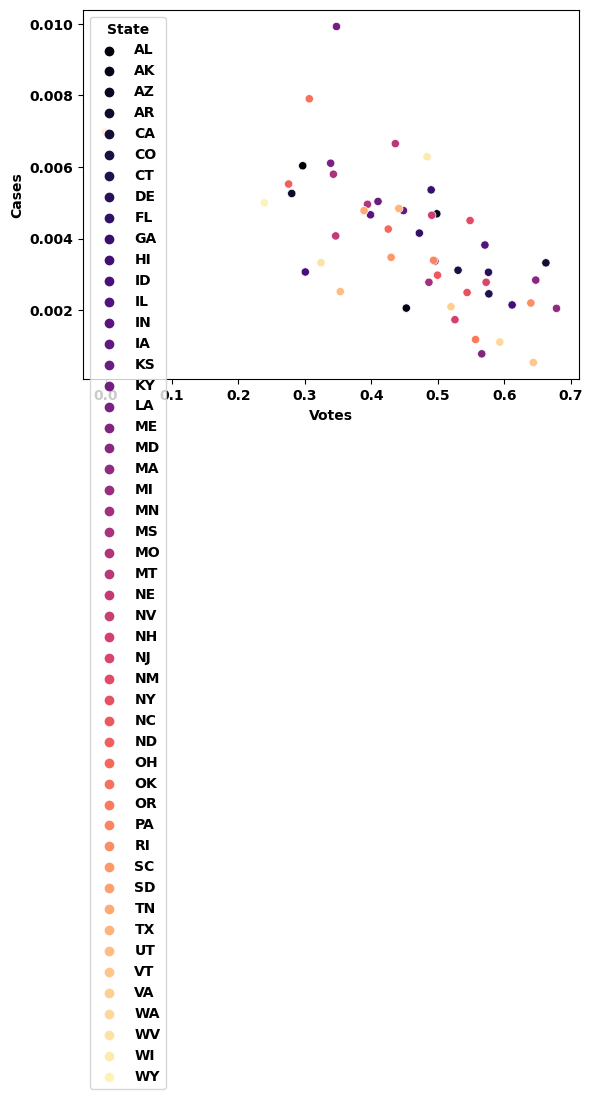

In [56]:
sns.scatterplot(plot_df_specific(votes_prop, cases_norm, 2020, 2020, 'DEMOCRAT'), x='Votes', y='Cases', hue='State', palette='magma')

<Axes: xlabel='Votes', ylabel='Cases'>

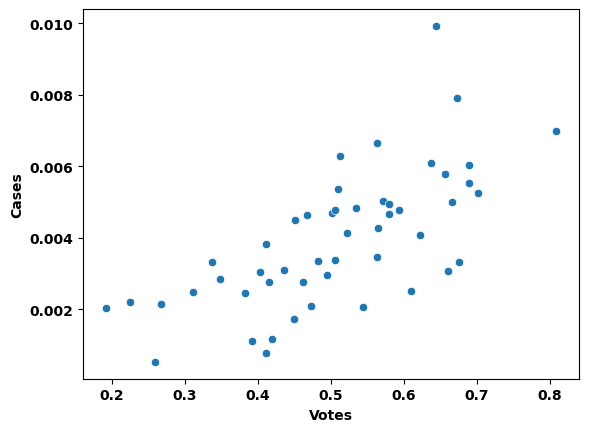

In [57]:
sns.scatterplot(plot_df(votes_prop, cases_norm, 2020, 'REPUBLICAN'), x='Votes', y='Cases')

<Axes: xlabel='Votes', ylabel='Cases'>

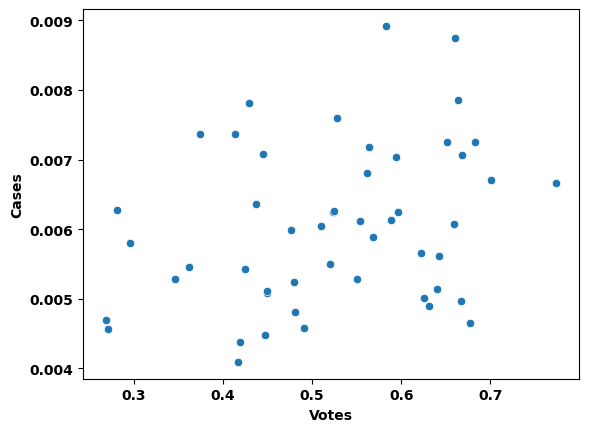

In [58]:
sns.scatterplot(plot_df(votes_prop, cases_norm, 2022, 'REPUBLICAN'), x='Votes', y='Cases')

<Axes: xlabel='Votes', ylabel='Cases'>

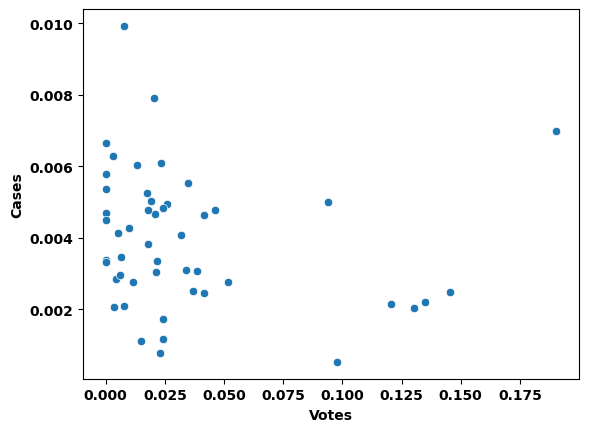

In [59]:
sns.scatterplot(plot_df(votes_prop, cases_norm, 2020, 'OTHER'), x='Votes', y='Cases')

<Axes: xlabel='Votes', ylabel='Cases'>

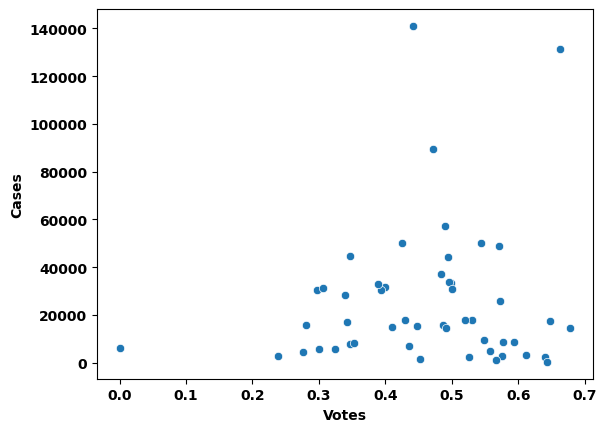

In [60]:
sns.scatterplot(plot_df(votes_prop, cases_by_year_state, 2020, 'DEMOCRAT'), x='Votes', y='Cases')

<Axes: xlabel='Votes', ylabel='Cases'>

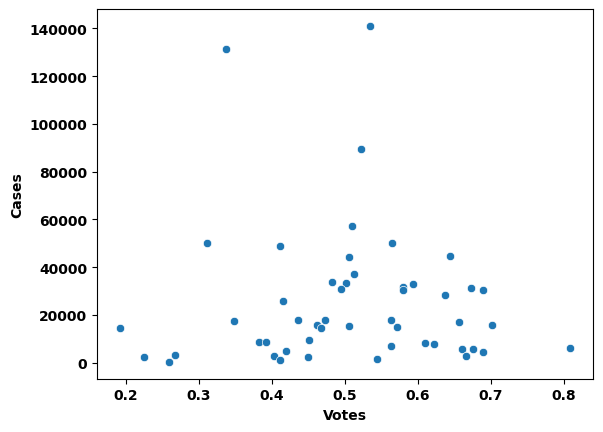

In [61]:
sns.scatterplot(plot_df(votes_prop, cases_by_year_state, 2020, 'REPUBLICAN'), x='Votes', y='Cases')

<Axes: xlabel='Votes', ylabel='Cases'>

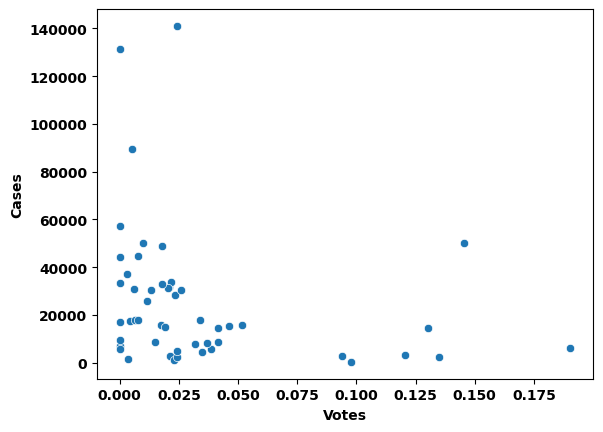

In [62]:
sns.scatterplot(plot_df(votes_prop, cases_by_year_state, 2020, 'OTHER'), x='Votes', y='Cases')

<Axes: xlabel='Votes', ylabel='Cases'>

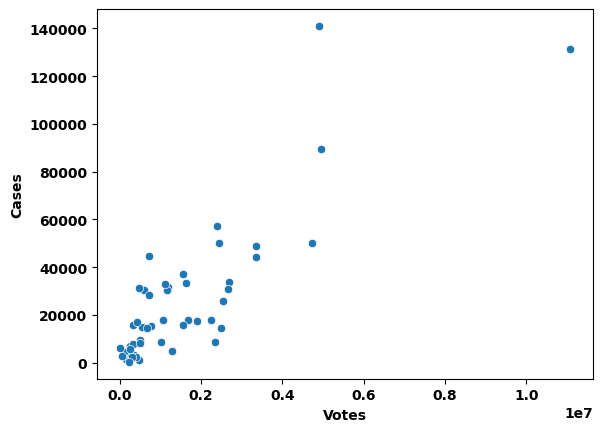

In [63]:
sns.scatterplot(plot_df(votes, cases_by_year_state, 2020, 'DEMOCRAT'), x='Votes', y='Cases')

<Axes: xlabel='Votes', ylabel='Cases'>

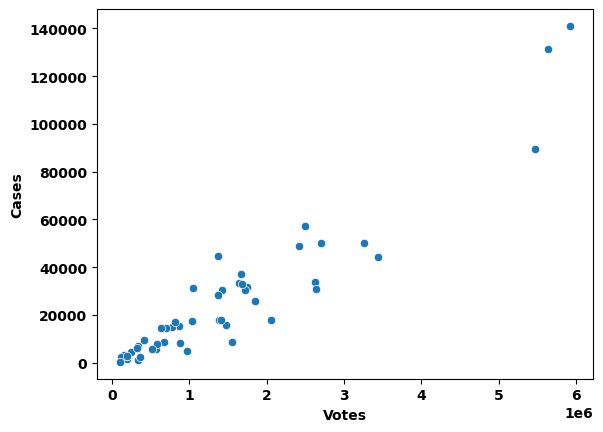

In [64]:
sns.scatterplot(plot_df(votes, cases_by_year_state, 2020, 'REPUBLICAN'), x='Votes', y='Cases')

<Axes: xlabel='Votes', ylabel='Cases'>

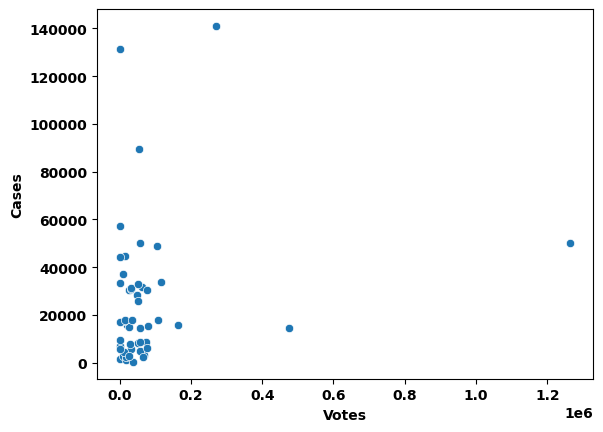

In [65]:
sns.scatterplot(plot_df(votes, cases_by_year_state, 2020, 'OTHER'), x='Votes', y='Cases')

In [66]:
# Making some nice colors for the different states
import matplotlib.colors as color
random_c_map = np.random.choice(list(color.CSS4_COLORS.keys()), replace=False, size=len(states))
state_to_color = zip(states, random_c_map)
print(list(state_to_color))


[('AL', 'mediumvioletred'), ('AK', 'azure'), ('AZ', 'coral'), ('AR', 'silver'), ('CA', 'midnightblue'), ('CO', 'orangered'), ('CT', 'lemonchiffon'), ('DE', 'darkslategray'), ('FL', 'orchid'), ('GA', 'brown'), ('HI', 'rosybrown'), ('ID', 'firebrick'), ('IL', 'darkgreen'), ('IN', 'gray'), ('IA', 'lawngreen'), ('KS', 'orange'), ('KY', 'lightgrey'), ('LA', 'mediumpurple'), ('ME', 'mediumturquoise'), ('MD', 'darkblue'), ('MA', 'palevioletred'), ('MI', 'yellow'), ('MN', 'gainsboro'), ('MS', 'thistle'), ('MO', 'mediumorchid'), ('MT', 'darkorchid'), ('NE', 'lime'), ('NV', 'goldenrod'), ('NH', 'steelblue'), ('NJ', 'blue'), ('NM', 'oldlace'), ('NY', 'grey'), ('NC', 'darkred'), ('ND', 'paleturquoise'), ('OH', 'peru'), ('OK', 'darkgrey'), ('OR', 'darkseagreen'), ('PA', 'dimgray'), ('RI', 'mediumaquamarine'), ('SC', 'sienna'), ('SD', 'chocolate'), ('TN', 'floralwhite'), ('TX', 'blanchedalmond'), ('UT', 'rebeccapurple'), ('VT', 'darkcyan'), ('VA', 'purple'), ('WA', 'moccasin'), ('WV', 'beige'), ('WI

Text(0, 0.5, 'COVID Cases')

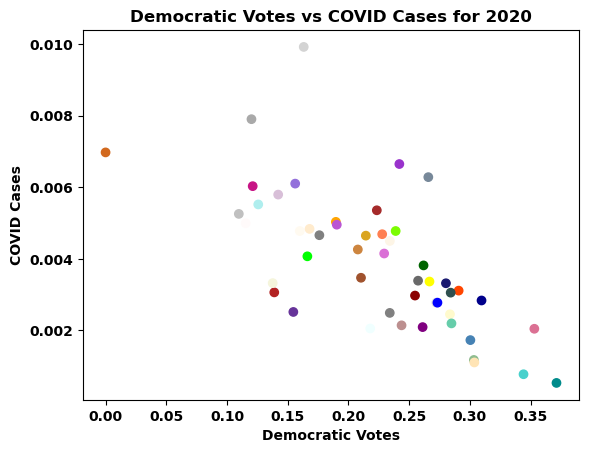

In [67]:
# Plotting Democratic Votes for 2020
x = []
y = []
for s in states:
    x.append(votes_norm[2020][s]['DEMOCRAT'])
    y.append(cases_norm[2020][s])
plt.scatter(x, y, c=random_c_map)
plt.title("Democratic Votes vs COVID Cases for 2020")
plt.xlabel("Democratic Votes")
plt.ylabel("COVID Cases")

Text(0, 0.5, 'COVID Cases')

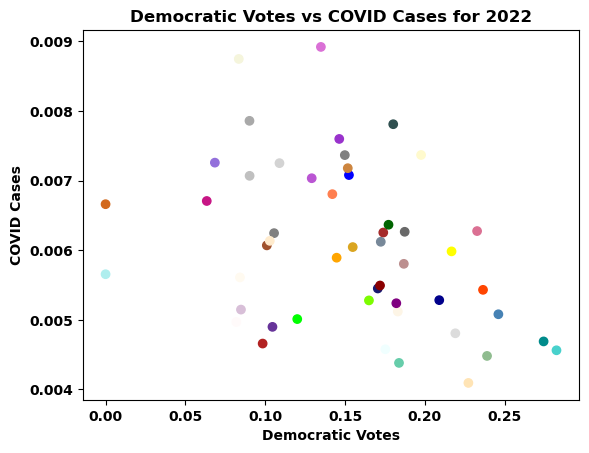

In [68]:
# Plotting Democratic Votes for 2022
x = []
y = []
for s in states:
    x.append(votes_norm[2022][s]['DEMOCRAT'])
    y.append(cases_norm[2022][s])
plt.scatter(x, y, c=random_c_map)
plt.title("Democratic Votes vs COVID Cases for 2022")
plt.xlabel("Democratic Votes")
plt.ylabel("COVID Cases")

Text(0, 0.5, 'COVID Cases')

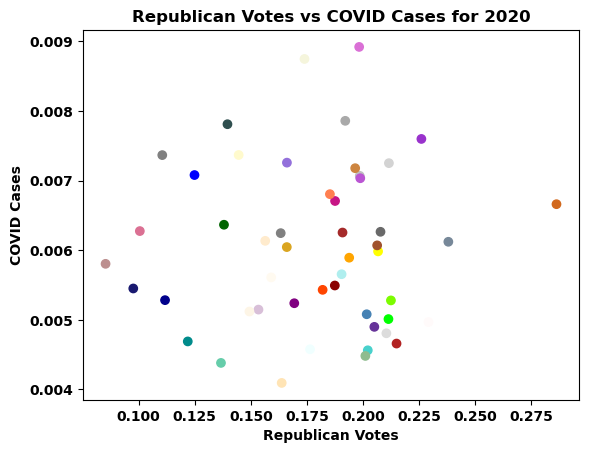

In [69]:
# Plotting Republican Votes for 2020
x = []
y = []
for s in states:
    x.append(votes_norm[2022][s]['REPUBLICAN'])
    y.append(cases_norm[2022][s])
plt.scatter(x, y, c=random_c_map)
plt.title("Republican Votes vs COVID Cases for 2020")
plt.xlabel("Republican Votes")
plt.ylabel("COVID Cases")

Text(0, 0.5, 'COVID Cases')

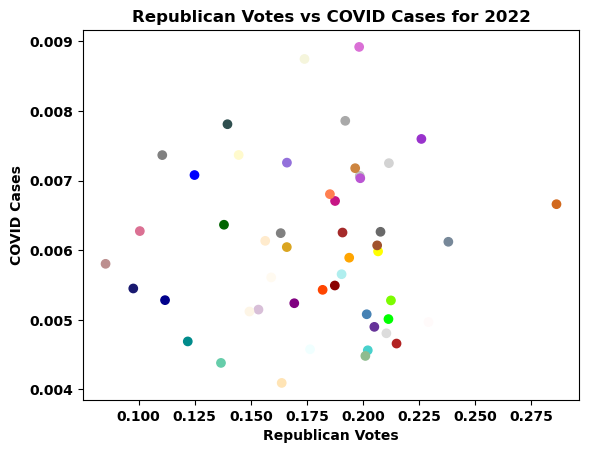

In [70]:
# Plotting Republican Votes for 2022
x = []
y = []
for s in states:
    x.append(votes_norm[2022][s]['REPUBLICAN'])
    y.append(cases_norm[2022][s])
plt.scatter(x, y, c=random_c_map)
plt.title("Republican Votes vs COVID Cases for 2022")
plt.xlabel("Republican Votes")
plt.ylabel("COVID Cases")

Text(0, 0.5, 'COVID Cases')

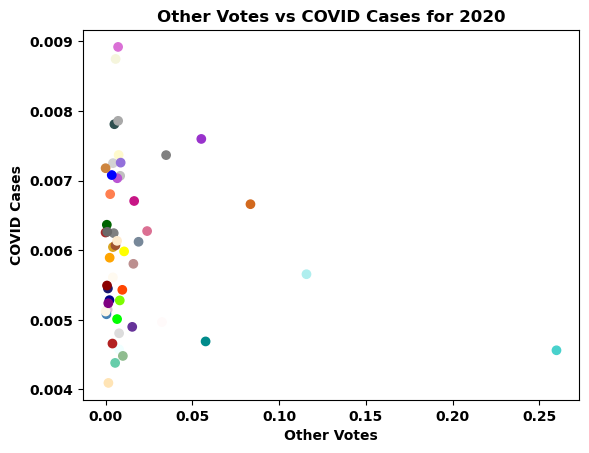

In [71]:
# Plotting Republican Votes for 2020
x = []
y = []
for s in states:
    x.append(votes_norm[2022][s]['OTHER'])
    y.append(cases_norm[2022][s])
plt.scatter(x, y, c=random_c_map)
plt.title("Other Votes vs COVID Cases for 2020")
plt.xlabel("Other Votes")
plt.ylabel("COVID Cases")

# KMeans
- votes_prop
- cases_norm

In [72]:
def data_to_arr(votes, cases, votes_year, cases_year, party):
    ret_arr = []
    for s in states:
        ret_arr.append(np.array([votes[votes_year][s][party], cases[cases_year][s]]))

    return np.array(ret_arr)

In [73]:
def plot_df_specific(votes, cases, votes_year, cases_year, party):
    # make the DF
    ret_df = pd.DataFrame(columns=['State', 'Votes', 'Cases'])
    for s in states:
        ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[votes_year][s][party]], 'Cases': [cases[cases_year][s]]})])

    return ret_df

In [74]:
def distance(l1, l2):
    # lists of (health, attack, defense)
    return np.sqrt(np.sum([(np.asarray(l1)-np.asarray(l2))**2]))


def kmeans(df, k=4, tol=0.01): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """    
    # initialize with random centroids
    choice_centroids = np.random.choice(range(len(df)), k, replace=False)
    centroids = []
    for i in range(len(choice_centroids)):
        row = df.iloc[choice_centroids[i], :]
        centroids.append([row.Votes, row.Cases])
        
    # start with an empty cluster array
    clusters = np.array([-1]*len(df))
    
    # iteration counter for fun and testing
    iter_count = 0
    
    # set up variables for the convergence check
    current_error = 0
    new_error = np.inf

    # iterate until there is little difference within the square error
    while(np.abs(current_error - new_error) > tol):
        # update the error of our current iteration
        current_error = new_error
        
        # assign to clusters
        for i in range(len(clusters)):
            row = df.iloc[i, :]
            input_list = [row.Votes, row.Cases]
            
            dists = [distance(input_list, cent) for cent in centroids]
        
            assignment = dists.index(min(dists))
            clusters[i] = assignment

        # update centroids
        for j in range(k):
            # print(len(df[clusters==j]))
            centroids[j] = [np.sum(df[clusters==j].Votes)/len(df[clusters==j]), \
                            np.sum(df[clusters==j].Cases)/len(df[clusters==j])]

        # calculate the error for each cluster
        clust_error = [0] * len(clusters)
        
        for i in range(len(clusters)):
            row = df.iloc[i, :]
            input_list = [row.Votes, row.Cases]
            clust_error[clusters[i]] += distance(centroids[clusters[i]], \
                                                 input_list) ** 2
            
        # set new error (average error of all the clusters)
        new_error = np.mean(clust_error)
        
        
    
    meanerror = new_error
    return centroids, clusters, meanerror

In [75]:
def plot_cluster(data, colors=['b','g', 'r'], k=3):
    assert(len(colors) >= k)
    _, clusters, _ = kmeans(data, k)
    colormap = []
    for i in range(len(clusters)):
        colormap.append(colors[clusters[i]])

    plt.scatter(data['Votes'], data['Cases'], c=colormap)
    return clusters

In [85]:
# Plot a 
def plot_cluster_optimized(data, colors=['b','g', 'r'], k=3, n_runs=20):
    assert(len(colors) >= k)
    all_runs = []
    all_means = []

    for i in range(n_runs):
        _, clusters, meanerror = kmeans(data, k)
        all_runs.append(clusters)
        all_means.append(meanerror)
        
    best_cluster = all_runs[all_means.index(np.min(all_means))]
    colormap = []
    for i in range(len(clusters)):
        colormap.append(colors[best_cluster[i]])

    plt.scatter(data['Votes'], data['Cases'], c=colormap)
    return best_cluster

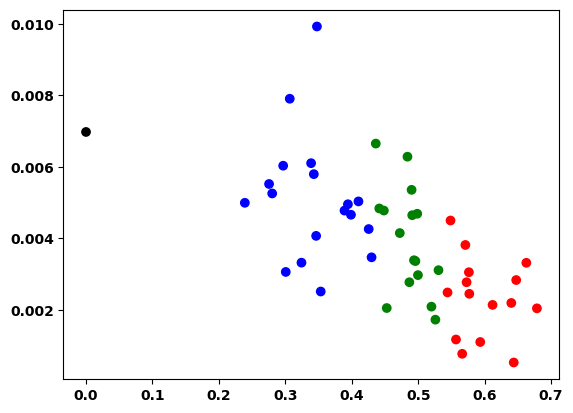

In [86]:
c_2020_v_2020_DEM = plot_df_specific(votes_prop, cases_norm, 2020, 2020, 'DEMOCRAT')
colors = ['r', 'g', 'b', 'k']
clusters = plot_cluster_optimized(c_2020_v_2020_DEM, colors, 4)

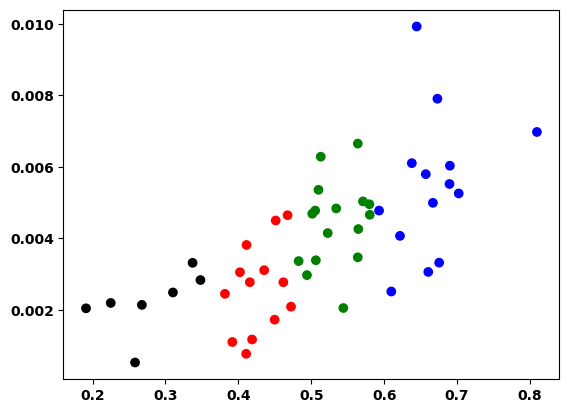

In [87]:
c_2020_v_2020_REP = plot_df_specific(votes_prop, cases_norm, 2020, 2020, 'REPUBLICAN')
colors = ['r', 'g', 'b', 'k']
clusters = plot_cluster_optimized(c_2020_v_2020_REP, colors, 4)

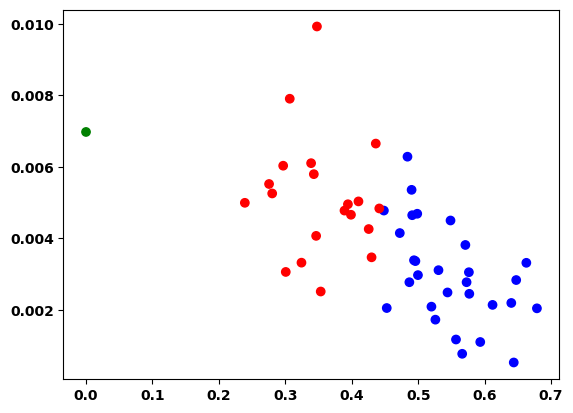

In [76]:
c_2020_v_2020_DEM = plot_df_specific(votes_prop, cases_norm, 2020, 2020, 'DEMOCRAT')
colors = ['r', 'g', 'b', 'k']
clusters = plot_cluster(c_2020_v_2020_DEM, colors, 3)

In [77]:
def plot_cluster_specific(data, clusters, colors=['b','g', 'r'], k=3):
    assert(len(colors) >= k)
    colormap = []
    for i in range(len(clusters)):
        colormap.append(colors[clusters[i]])

    plt.scatter(data['Votes'], data['Cases'], c=colormap)
    return clusters

[(0, 'CA'), (0, 'HI'), (0, 'MD'), (0, 'MA'), (0, 'NY'), (0, 'RI'), (0, 'VT'), (1, 'AL'), (1, 'AR'), (1, 'ID'), (1, 'IN'), (1, 'KS'), (1, 'KY'), (1, 'LA'), (1, 'MS'), (1, 'MO'), (1, 'MT'), (1, 'NE'), (1, 'ND'), (1, 'OH'), (1, 'OK'), (1, 'SC'), (1, 'SD'), (1, 'TN'), (1, 'UT'), (1, 'WV'), (1, 'WY'), (2, 'AK'), (2, 'AZ'), (2, 'CO'), (2, 'CT'), (2, 'DE'), (2, 'FL'), (2, 'GA'), (2, 'IL'), (2, 'IA'), (2, 'ME'), (2, 'MI'), (2, 'MN'), (2, 'NV'), (2, 'NH'), (2, 'NJ'), (2, 'NM'), (2, 'NC'), (2, 'OR'), (2, 'PA'), (2, 'TX'), (2, 'VA'), (2, 'WA'), (2, 'WI')]


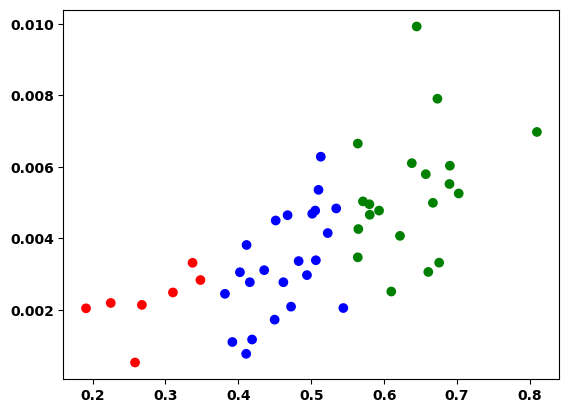

In [78]:
# Do multiple runs and print clustering with the lowest mean error
num_runs = 20
k = 3
all_runs_dem = []
all_means_dem = []

c_2020_v_2020_DEM = plot_df_specific(votes_prop, cases_norm, 2020, 2020, 'REPUBLICAN')

for i in range(num_runs):
    _, clusters, meanerror = kmeans(c_2020_v_2020_DEM, k)
    all_runs_dem.append(clusters)
    all_means_dem.append(meanerror)
    
min_index = all_means_dem.index(np.min(all_means_dem))
plot_cluster_specific(c_2020_v_2020_DEM, all_runs_dem[min_index], ['r','g','b','k'], 3)
print(sorted(list(zip(list(all_runs_dem[min_index]), states)), key=lambda x: x[0]))

In [79]:
def plot_cluster_sklearn(data, colors=['b','g', 'r'], k=3):
    assert(len(colors) >= k)
    clusters = KMeans(n_clusters=k, n_init='auto').fit(data).labels_
    colormap = []
    for i in range(len(clusters)):
        colormap.append(colors[clusters[i]])

    plt.scatter(data[:,0], data[:,1], c=colormap)
    return clusters


c:\Users\meowm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


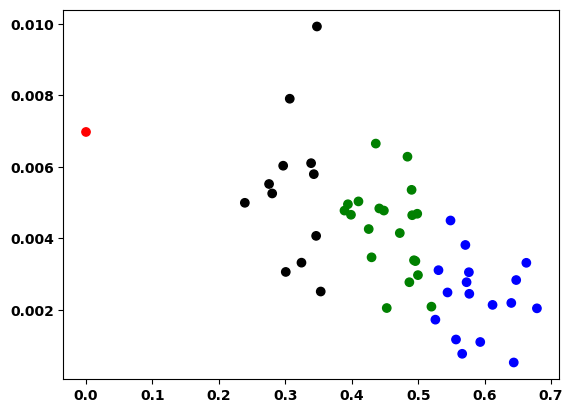

In [81]:
colors = ['blue', 'green', 'red', 'black']
cases_2020_votes_2020_DEM = data_to_arr(votes_prop, cases_norm, 2020, 2020, 'DEMOCRAT')
clusters = plot_cluster_sklearn(cases_2020_votes_2020_DEM, colors, 4)

In [55]:
print(sorted(list(zip(clusters, states)), key=lambda x: x[0]))

[(0, 'AK'), (0, 'AZ'), (0, 'FL'), (0, 'GA'), (0, 'IN'), (0, 'IA'), (0, 'KS'), (0, 'MI'), (0, 'MN'), (0, 'MO'), (0, 'MT'), (0, 'NV'), (0, 'NC'), (0, 'OH'), (0, 'PA'), (0, 'SC'), (0, 'TN'), (0, 'TX'), (0, 'VA'), (0, 'WI'), (1, 'CA'), (1, 'CO'), (1, 'CT'), (1, 'DE'), (1, 'HI'), (1, 'IL'), (1, 'ME'), (1, 'MD'), (1, 'MA'), (1, 'NH'), (1, 'NJ'), (1, 'NM'), (1, 'NY'), (1, 'OR'), (1, 'RI'), (1, 'VT'), (1, 'WA'), (2, 'AL'), (2, 'AR'), (2, 'ID'), (2, 'KY'), (2, 'LA'), (2, 'MS'), (2, 'NE'), (2, 'ND'), (2, 'OK'), (2, 'UT'), (2, 'WV'), (2, 'WY')]


c:\Users\meowm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


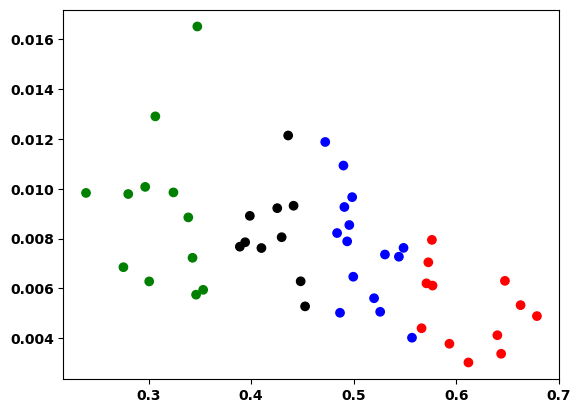

In [47]:
colors = ['blue', 'green', 'red', 'black']
cases_2021_votes_2020_DEM = data_to_arr(votes_prop, cases_norm, 2020, 2021, 'DEMOCRAT')
clusters = plot_cluster(cases_2021_votes_2020_DEM, colors, 4)

In [48]:
cluster_states = sorted(zip(clusters, states), key=lambda x: x[0])
print(cluster_states)

[(0, 'AZ'), (0, 'CO'), (0, 'FL'), (0, 'GA'), (0, 'MI'), (0, 'MN'), (0, 'NV'), (0, 'NH'), (0, 'NM'), (0, 'NY'), (0, 'NC'), (0, 'OR'), (0, 'PA'), (0, 'VA'), (0, 'WI'), (1, 'AL'), (1, 'AR'), (1, 'ID'), (1, 'KY'), (1, 'LA'), (1, 'MS'), (1, 'NE'), (1, 'ND'), (1, 'OK'), (1, 'UT'), (1, 'WV'), (1, 'WY'), (2, 'CA'), (2, 'CT'), (2, 'DE'), (2, 'HI'), (2, 'IL'), (2, 'ME'), (2, 'MD'), (2, 'MA'), (2, 'NJ'), (2, 'RI'), (2, 'VT'), (2, 'WA'), (3, 'AK'), (3, 'IN'), (3, 'IA'), (3, 'KS'), (3, 'MO'), (3, 'MT'), (3, 'OH'), (3, 'SC'), (3, 'TN'), (3, 'TX')]


In [95]:
def elbow_plot(data, ks, title="Elbow plot"):
    inertias = []
    for k in ks:
        # repeat the kmeans algo 10 times for each k
        # to get a more accurate measure
        k_inertias = []
        for i in range(10):
            _, _, meanerror = kmeans(data, k)
            k_inertias.append(meanerror)
        inertias.append(np.min(k_inertias))
    
    plt.scatter(ks, inertias)
    plt.title(title)
    plt.xlabel("k")
    plt.ylabel("Mean Error")

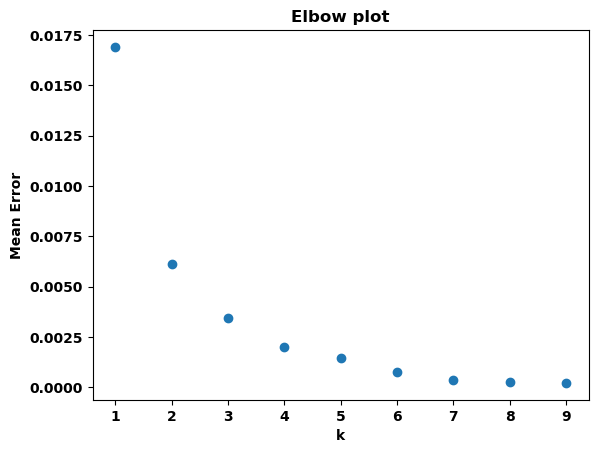

In [96]:
elbow_plot(c_2020_v_2020_DEM, list(range(1,10)))

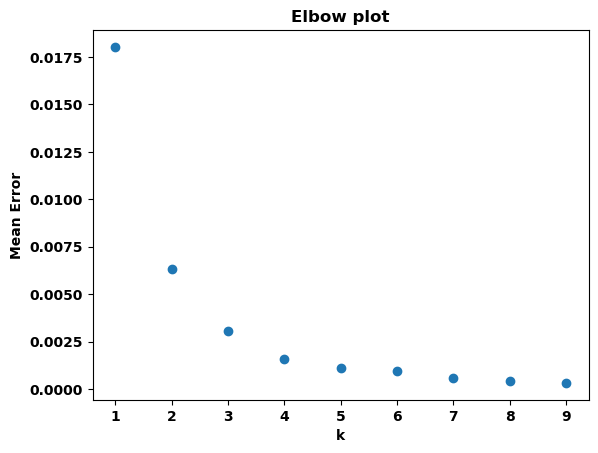

In [97]:
elbow_plot(c_2020_v_2020_REP, list(range(1,10)))

c:\Users\meowm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\meowm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\meowm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\meowm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

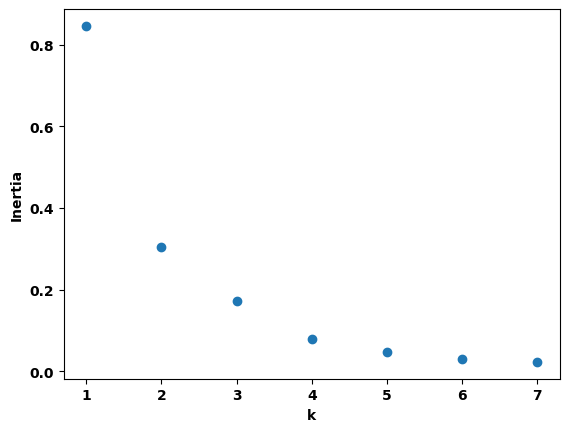

In [88]:
def elbow_plot_sklearn(data, ks):
    inertias = []
    for k in ks:
        intertia = KMeans(n_clusters=k, n_init='auto').fit(data).inertia_
        inertias.append(intertia)
    
    plt.scatter(ks, inertias)
    plt.xlabel("k")
    plt.ylabel("Inertia")


elbow_plot_sklearn(cases_2020_votes_2020_DEM, list(range(1, 8)))

# Notes
- South Dakota has no Democratic party for its House of Representatives elections (only Republican and Libertarian)
    - Removing it means that 3 becomes the optimal clustering method

# Functions For Plotting

In [100]:
# Returns an DataFrame with State, Votes, and Cases for specified years and party
# All functions below will use the DataFrame returned from this
# function as it sets up the correct column names for the rest of the functions
def plot_df_specific(votes, cases, votes_year, cases_year, party):
    # make the DF
    ret_df = pd.DataFrame(columns=['State', 'Votes', 'Cases'])
    for s in states:
        ret_df = pd.concat([ret_df, pd.DataFrame({'State': [s], 'Votes': [votes[votes_year][s][party]], 'Cases': [cases[cases_year][s]]})])

    return ret_df

In [ ]:
# Simple L2 Norm for distance measure
def distance(l1, l2):
    return np.sqrt(np.sum([(np.asarray(l1)-np.asarray(l2))**2]))

# kmeans algo developed in HW 3, changed to fit this problem,
# more specifically, to be used with the DataFrame from
# plot_df_specific(...) as it has the correct column names
def kmeans(df, k=4, tol=0.01): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """    
    # initialize with random centroids
    choice_centroids = np.random.choice(range(len(df)), k, replace=False)
    centroids = []
    for i in range(len(choice_centroids)):
        row = df.iloc[choice_centroids[i], :]
        centroids.append([row.Votes, row.Cases])
        
    # start with an empty cluster array
    clusters = np.array([-1]*len(df))
    
    # iteration counter for fun and testing
    iter_count = 0
    
    # set up variables for the convergence check
    current_error = 0
    new_error = np.inf

    # iterate until there is little difference within the square error
    while(np.abs(current_error - new_error) > tol):
        # update the error of our current iteration
        current_error = new_error
        
        # assign to clusters
        for i in range(len(clusters)):
            row = df.iloc[i, :]
            input_list = [row.Votes, row.Cases]
            
            dists = [distance(input_list, cent) for cent in centroids]
        
            assignment = dists.index(min(dists))
            clusters[i] = assignment

        # update centroids
        for j in range(k):
            # print(len(df[clusters==j]))
            centroids[j] = [np.sum(df[clusters==j].Votes)/len(df[clusters==j]), \
                            np.sum(df[clusters==j].Cases)/len(df[clusters==j])]

        # calculate the error for each cluster
        clust_error = [0] * len(clusters)
        
        for i in range(len(clusters)):
            row = df.iloc[i, :]
            input_list = [row.Votes, row.Cases]
            clust_error[clusters[i]] += distance(centroids[clusters[i]], \
                                                 input_list) ** 2
            
        # set new error (average error of all the clusters)
        new_error = np.mean(clust_error)
        
        
    
    meanerror = new_error
    return centroids, clusters, meanerror

In [101]:
# Funtion to make an elbowplot of, slightly optimized
# by the n_runs variable
def elbow_plot(data, ks, title="Elbow plot", n_runs=10):
    inertias = []
    for k in ks:
        # repeat the kmeans algo n_runs times for each k
        # to get a more accurate measure
        k_inertias = []
        for i in range(n_runs):
            _, _, meanerror = kmeans(data, k)
            k_inertias.append(meanerror)
        # only plot the best meanerror found for the value of k
        inertias.append(np.min(k_inertias))
    
    # plot
    plt.scatter(ks, inertias)
    plt.title(title)
    plt.xlabel("k")
    plt.ylabel("Mean Error")

In [102]:
# Function to plot a specific cluster on the data
def plot_cluster_specific(data, clusters, colors=['b','g', 'r'], k=3):
    assert(len(colors) >= k)
    colormap = []
    for i in range(len(clusters)):
        colormap.append(colors[clusters[i]])

    plt.scatter(data['Votes'], data['Cases'], c=colormap)
    return clusters

In [103]:
# Plotting data after (default) 20 runs of the kmeans algorithms
# to get a more optimized result
def plot_data_optimized(data, colors=['b','g', 'r'], k=3, n_runs=20):
    assert(len(colors) >= k)
    all_runs = []
    all_means = []

    for i in range(n_runs):
        _, clusters, meanerror = kmeans(data, k)
        all_runs.append(clusters)
        all_means.append(meanerror)
        
    best_cluster = all_runs[all_means.index(np.min(all_means))]
    colormap = []
    for i in range(len(clusters)):
        colormap.append(colors[best_cluster[i]])

    plt.scatter(data['Votes'], data['Cases'], c=colormap)
    return best_cluster

# Notes on Data
House: Bad: Votes, **good: votes_prop**  
- votes for a party in a state and year divided by the total votes in that state and year. 

COVID: bad: cases_by_year_state, **good: cases_norm**  
- total adult and pediatric cases for a state divided by that state's 2020 Census population  

# Democrat 2020 House, 2020 COVID